In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def get_option_termination_states(options, states, n_options=4):
    termination_states = {x: [] for x in range(n_options)}
    for episode in range(len(options)):
        option_trajectory = options[episode]
        for i in range(len(option_trajectory)-1):
            if option_trajectory[i] != option_trajectory[i+1]:
                term_state = states[episode][i-1]
#                 if term_state not in termination_states[option_trajectory[i]]:
                termination_states[option_trajectory[i]].append(term_state)
    return termination_states


def coords_to_onehot(coords, boundaries):
    dim = np.prod(boundaries)
    w, h = boundaries
    x = np.zeros(dim)
    idx = coords[0] * w + coords[1]  # this should be w !!!!!!
    x[idx] = 1
    return x


In [3]:
def load_episode_data(directory, exclude=None):
    files = [f for f in os.listdir(directory) if os.path.isfile(directory+f)]
    episode_data = pd.DataFrame()
    for f in files:
        episode_data = episode_data.append(pd.read_pickle(directory+f), ignore_index=True)
    episode_data = episode_data.sort_values('episode')
    episode_data = episode_data.reset_index(drop=True)
    episode_data.episode = [int(x) for x in episode_data.episode]
#     episode_data = episode_data[['episode', 'action', 'reward', 'state', 'logprob', 'mask']]
    return episode_data

In [4]:
def get_terms(terminations, coords, options, n_options=4):
    termination_states = {x: [] for x in range(n_options)}
    for i, episode in enumerate(terminations):
        for j, term in enumerate(episode):
            if term and j > 0:
                termination_states[options[i][j-1]].append(coords[i][j])
    return termination_states

In [10]:
def unpack_env_data(df):
    keys = list(df.env_data)[0][0].keys()
    for k in keys:
        df[k] = [[x[k] for x in y] for y in df.env_data]
    return df

In [132]:
def simulate_step(df, episode, current_idx):
    for key, item in df.env_data[episode][current_idx].items():
        print('{}: {}'.format(key, item))
    print('action: {}'.format(df.action[episode][current_idx]))
    print('reward: {}'.format(df.reward[episode][current_idx]))
    return current_idx + 1

In [58]:
summary = pd.read_pickle('../experiments/ppo3_done_gamma1_reward100_ppo_lightbot_cross/summary.p')

In [7]:
df = load_episode_data('../experiments/ppo4_nodecay_3e-4_gamma09_ppo_lightbot_cross/episodes/')

In [8]:
df['total_reward'] = [np.sum(x) for x in df.reward]

In [11]:
df = unpack_env_data(df)

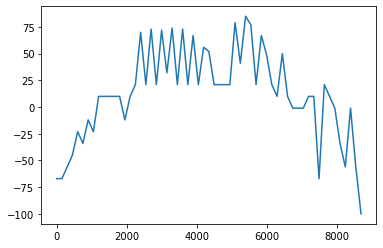

In [15]:
every=150
plt.plot(df.episode[::every], df.total_reward[::every])

In [70]:
T = get_terms(df.terminate, df.coords, df.option)

In [133]:
idx = 0

In [208]:
idx = simulate_step(df, 0, idx)

coords: (0, 0)
height: 1
direction: 1
light_idx: -1
lights_on: [0 0 0 0 0 0 1 0 0 0 1 0]
action: 0
reward: -1.0


In [136]:
df.loc[0]

action          [2, 2, 2, 1, 1, 2, 3, 2, 2, 2, 2, 3, 1, 4, 3, ...
env_data        [{'coords': (0, 0), 'height': 1, 'direction': ...
episode                                                         0
logprob         [-1.4334884881973267, -1.4334884881973267, -1....
mask            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
reward          [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....
state           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
total_reward                                                 -223
coords          [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0...
height          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...
direction       [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 3, 2, ...
light_idx       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
lights_on       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, ...
Name: 0, dtype: object

In [31]:
len(df)

20000

In [19]:
df['coords'] = [[x['coords'] for x in y] for y in df.env_data]

In [89]:
term_states = get_option_termination_states(list(df.option)[15000:], list(df.coords)[15000:])

In [77]:
len(term_states)

4

In [49]:
def plot_treads(coords, gridsize):
    grid = np.zeros(gridsize)
    for episode in coords:
        for state in episode:
            grid[state[0], state[1]] += 1
    return grid

In [56]:
inits = [[x[0]] for x in df.coords]
G = plot_treads(inits, (5,5))

In [55]:
init_dir = [x[0] for x in df.direction]

In [34]:
dirs = [y for x in df.direction for y in x]

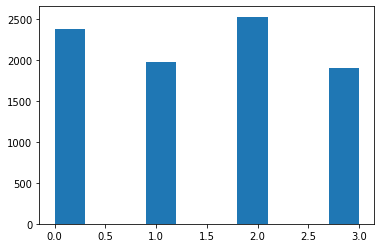

In [27]:
plt.hist(init_dir);

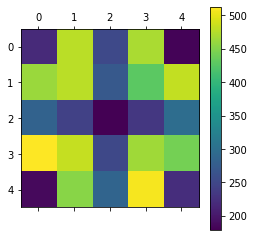

In [57]:
plt.matshow(G)
plt.colorbar()

In [39]:
def termination_grids(term_states, gridsize):
    n_options = len(term_states)
    grids = {x: np.zeros(gridsize) for x in range(n_options)}
    for o in range(n_options):
        for s in term_states[o]:
            grids[o][s] += 1
    return grids

In [90]:
grids = termination_grids(term_states, (13,13))

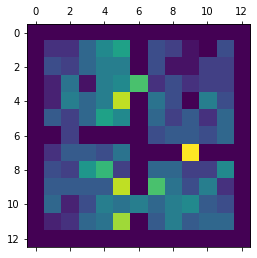

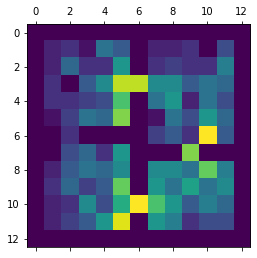

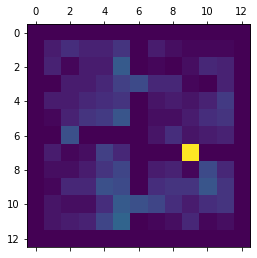

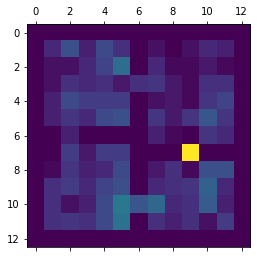

In [91]:
for i,grid in grids.items():
    plt.matshow(grid)